In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pacmagic_deeplearning.modeling.classifiers.bayesian.train_utils import make_performance_uncertainty_plot, cross_entropy
from torchvision.datasets import CIFAR10
from torchvision import transforms
from tqdm.auto import tqdm
from PIL import Image

In [2]:
train_dataset = CIFAR10('../data/CIFAR10/', download=True, transform=transforms.ToTensor())
test_dataset = CIFAR10('../data/CIFAR10/', download=True, train=False, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))
test_data, test_labels = next(iter(test_loader))

In [4]:
def log_softmax(outputs, dim=-1, t=1):
    # Stability: https://stackoverflow.com/questions/44081007/logsoftmax-stability
    b = torch.max(outputs, dim=dim, keepdim=True)[0]
    return (outputs - b) * t - torch.log(torch.sum(torch.exp(t * (outputs - b)), dim=dim, keepdim=True))

In [5]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        quantiles = 3
        self.fe = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, kernel_size=3),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.MaxPool2d(2),
        )
        self.quantile_preds = nn.ModuleList([nn.Linear(256, 10) for _ in range(quantiles)])
        
    def forward(self, x):
        z = self.fe(x).view(x.shape[0], -1)
        return [self.quantile_preds[i](z) for i in range(len(self.quantile_preds))]

In [6]:
model = NN()

In [7]:
# optimizer = SGD(model.parameters(), lr=5e-1, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
# best_val_loss = np.inf
# patience = 0
# temperatures = [0.5, 1, 2]

# for epoch_idx in range(10000):
    
#     for data, target in tqdm(train_loader):
#         outputs = model(data)
#         losses = [temperatures[i] * torch.nn.functional.cross_entropy(
#             outputs[i], 
#             target, 
#         ) for i in range(len(outputs))]

#         loss = sum(losses)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
    
#     if epoch_idx % 1 == 0:
#         outputs_val = model(test_data)
#         losses_val = [temperatures[i] * torch.nn.functional.cross_entropy(
#             outputs_val[i], 
#             test_labels
#         ) for i in range(len(outputs))]
    
#         loss_val = sum(losses_val) 
        
#         print(loss_val.item())
            
#         if loss_val.item() < best_val_loss:
#             best_val_loss = loss_val.item()
#             torch.save(model.state_dict(), 'tmp.pth')
#         else:
#             patience += 1
            
#             if patience == 8:
#                 model.load_state_dict(torch.load('tmp.pth'))
#                 break
    

In [9]:
best_val_loss = np.inf
patience = 0
temperatures = [0.5, 1, 2]

for epoch_idx in range(10000):
    
    for data, target in tqdm(train_loader):
        outputs = model(data)
        losses = [torch.nn.functional.nll_loss(
            log_softmax(outputs[i], t=temperatures[i]), 
            target
        ) for i in range(len(outputs))]

        loss = sum(losses)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch_idx % 1 == 0:
        outputs_val = model(test_data)
        losses_val = [torch.nn.functional.nll_loss(
            log_softmax(outputs_val[i], t=temperatures[i]), 
            test_labels
        ) for i in range(len(outputs_val))]
    
        loss_val = sum(losses_val) 
        
        print(loss_val.item())
            
        if loss_val.item() < best_val_loss:
            best_val_loss = loss_val.item()
            torch.save(model.state_dict(), 'tmp.pth')
        else:
            patience += 1
            
            if patience == 8:
                model.load_state_dict(torch.load('tmp.pth'))
                break
    


5.570899486541748



5.06559944152832



4.685979843139648



4.441023826599121



4.254605293273926



4.137251853942871



4.052804470062256



3.982494354248047



3.9231934547424316



3.8689589500427246



3.8140883445739746



3.7588648796081543



3.705113172531128



3.6556408405303955



3.6122941970825195



3.572460651397705



3.53739595413208



3.50693941116333



3.4786972999572754



3.450033664703369



3.419987440109253



3.3926258087158203



3.3702802658081055



3.3545329570770264



3.339306116104126



3.321732521057129



3.304305076599121



3.2884602546691895



3.2734851837158203



3.2598371505737305



3.247748613357544



3.236553430557251



3.2259974479675293



3.2167487144470215



3.207581043243408



3.1990966796875



3.1907691955566406



3.183479070663452



3.1758229732513428



3.1691036224365234



3.162827253341675



3.156857967376709



3.150965690612793



3.1458325386047363



3.141685962677002



3.1376771926879883



3.1337785720825195



3.1299033164978027



3.1260976791381836



3.1236538887023926



3.1208713054656982



3.1182336807250977



3.115694522857666



3.1138057708740234



3.1115541458129883



3.109769344329834



3.10882306098938



3.1075735092163086



3.1079189777374268



3.108227491378784



3.1087470054626465



3.109715461730957



3.1116349697113037



3.1137020587921143



3.116034984588623



3.1159443855285645


In [54]:
with torch.no_grad():
    out_conf, out, out_diff = model(test_data)

In [55]:
out_conf, out, out_diff = torch.softmax(out_conf, dim=-1).numpy(), torch.softmax(out, dim=-1).numpy(), torch.softmax(out_diff, dim=-1).numpy()

In [12]:
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

In [13]:
entropy(out_conf.T).mean(), entropy(out.T).mean(), entropy(out_diff.T).mean()

(0.47014746, 0.8805854, 1.472975)

In [44]:
uncs = out_conf - out_diff

In [25]:
preds = out.argmax(-1)

In [26]:
M = uncs[range(len(uncs)), preds]


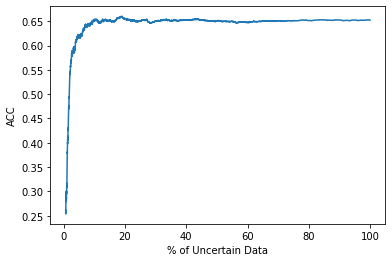

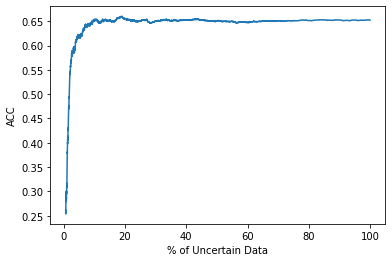

In [27]:
make_performance_uncertainty_plot(test_labels.numpy(), preds, M, 'ACC', performance_fn=accuracy_score)

In [34]:
uncs = (entropy(out_diff.T) - entropy(out_conf.T))

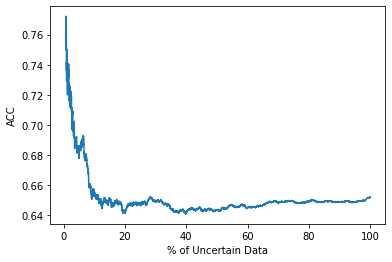

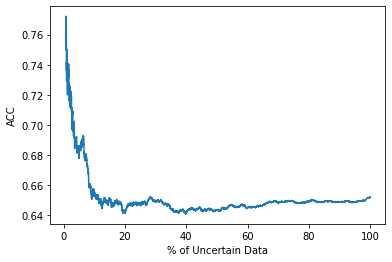

In [45]:

make_performance_uncertainty_plot(test_labels.numpy(), preds, uncs, 'ACC', performance_fn=accuracy_score)

In [37]:
y * (1 - 6))*D_KL(U| p(y|x)) 

array([3, 8, 8, ..., 5, 1, 7])

In [42]:
cross_entropy(test_labels, out, n_labels=10)

array([1.02316689, 1.15887678, 0.41626149, ..., 0.07128917, 1.28670824,
       0.13041002])

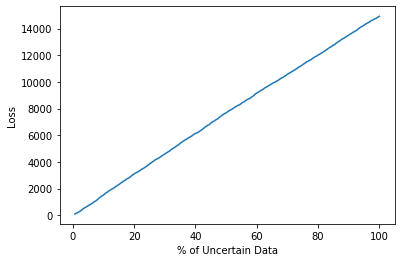

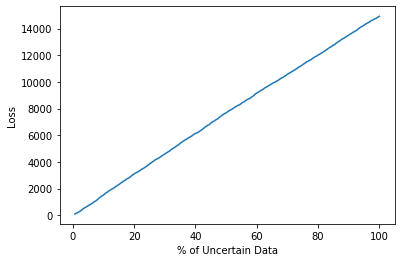

In [46]:
make_performance_uncertainty_plot(test_labels.numpy(), preds, uncs, 'Loss', performance_fn_args={'reduction': 'sum'})

In [47]:
uncs = entropy(out.T)

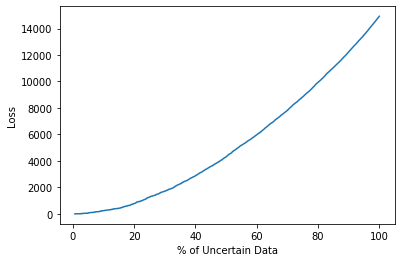

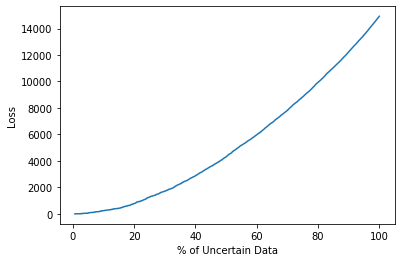

In [60]:
make_performance_uncertainty_plot(test_labels.numpy(), out, uncs, 'Loss', performance_fn_args={'reduction': 'sum',
                                                                                              'n_labels': 10})

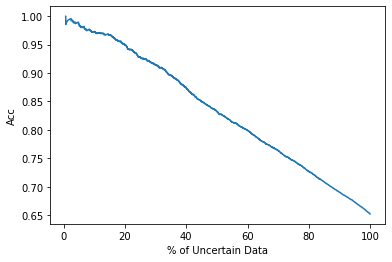

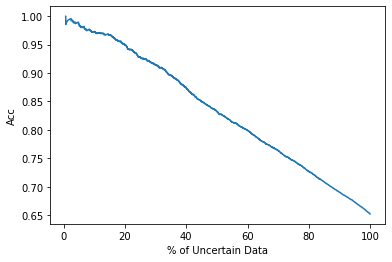

In [62]:
make_performance_uncertainty_plot(test_labels.numpy(), preds, uncs, 'Acc', performance_fn=accuracy_score)